In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import multiprocessing
from   math import ceil, floor

In [2]:
on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if on_gpu else "cpu")

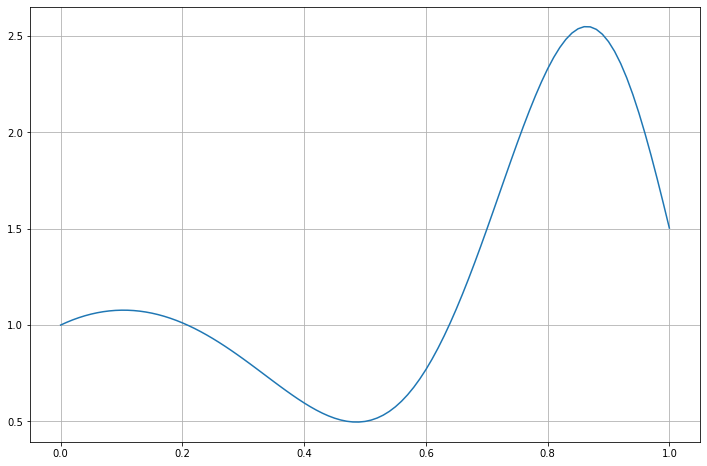

In [3]:
# Подбираем вид функции, которую будем апроксимировать с помощью НС
step = 0.01
xf = 0.0
xt = 1.0

xs = np.arange(xf, xt + step, step)

# Детерминированная зависимость (без шума) y от  x
def y_f(x):
    return 1 - x*x + 1.5*x - np.sin(2 * 3.14 * x*x);

ys = y_f(xs)

plt.figure(figsize=(12, 8))
plt.grid(True)
plt.plot(xs, ys)
plt.show()

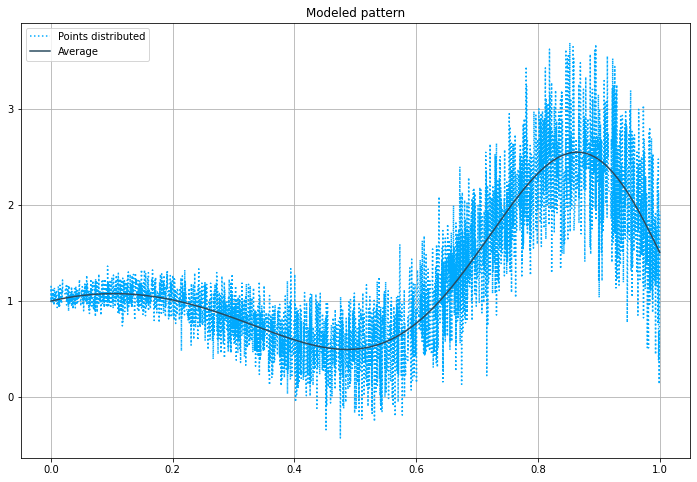

In [4]:
# Генерируем обучающий набор случайных точке с заданным распределением

N_X = 3000 # Количество точек в наборе

# x равномерно распределены в [0, 1]
xs = np.random.uniform(0, 1, N_X)
xs.sort()

# Отклонения Y от детерминированного значения будут распределены нормально
sigmf = lambda x : 0.05 + x/2.0
ys    = [np.random.normal(y_f(xs[i]), sigmf(xs[i]), 1)[0] for i in range(len(xs))]
avgs  = [y_f(xs[i]) for i in range(len(xs))]
             

plt.figure(figsize=(12, 8))
plt.grid(True)
plt.plot(xs, ys,   color="#00aaff", linestyle='dotted', label='Points distributed')
plt.plot(xs, avgs, color="#294a5f", linestyle='solid',  label='Average')

plt.title("Modeled pattern")
plt.legend()
plt.show()

## Модель регрессии / Regression model

In [5]:
D_in, D_out = 1, 1
H1, H2      = 250, 150

model_regr = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.Tanh(),
    torch.nn.Linear(H2, D_out),
)

if on_gpu:
    model_regr = model_regr.to(device)
else:
    torch.set_num_threads(multiprocessing.cpu_count())

print(model_regr)

Sequential(
  (0): Linear(in_features=1, out_features=250, bias=True)
  (1): ReLU()
  (2): Linear(in_features=250, out_features=150, bias=True)
  (3): Tanh()
  (4): Linear(in_features=150, out_features=1, bias=True)
)


In [6]:
learning_rate  = 0.01
epochs         = 1000
ep_step        = epochs//10

optimizer_regr = torch.optim.Adam(model_regr.parameters(), lr = learning_rate)
loss_fn_regr   = torch.nn.MSELoss()

100 0.15325190126895905
200 0.13575255870819092
300 0.1198636144399643
400 0.11363904178142548
500 0.11317799985408783
600 0.1130155548453331
700 0.11290852725505829
800 0.11282424628734589
900 0.11275406926870346
1000 0.11269862949848175


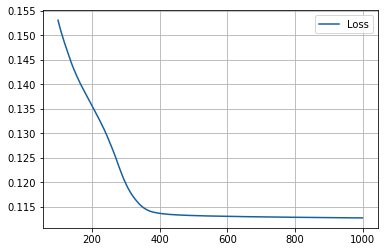

In [7]:
preds = []
y_pred = None

indexes = list(range(len(xs)))
random.shuffle(indexes)

vecx = torch.tensor([[xs[i]] for i in indexes], dtype=torch.float32).to(device)
vecy = torch.tensor([[ys[i]] for i in indexes], dtype=torch.float32).to(device)

losses = [];
for epoch in range(epochs):
    y_pred = model_regr(vecx)
    
    loss_regr = loss_fn_regr(y_pred, vecy)
    
    optimizer_regr.zero_grad()
    optimizer_regr.lr = learning_rate * 2.0 / (epoch + 1)

    loss_regr.backward()

    optimizer_regr.step()
    
    loss = loss_regr.item()
    losses.append(loss)
    
    if (epoch+1) % ep_step == 0:
        print((epoch+1), loss)


plt.grid(True)
plt.plot(range(100, epochs), losses[100:], color="#1660a1", linestyle='solid', label='Loss')
plt.legend()
plt.show()

In [8]:
step = 0.01
xf = 0.0
xt = 1.0

xps = np.arange(xf, xt, step)
vecpx = torch.tensor([[x] for x in xps], dtype=torch.float32).to(device)
vecpy = torch.tensor([[y_f(x)] for x in xps], dtype=torch.float32).to(device)

y_pred = model_regr(vecpx)

loss_regr = loss_fn_regr(y_pred, vecpy)
print("loss_regr", loss_regr.item())

loss_regr 0.0006501991883851588


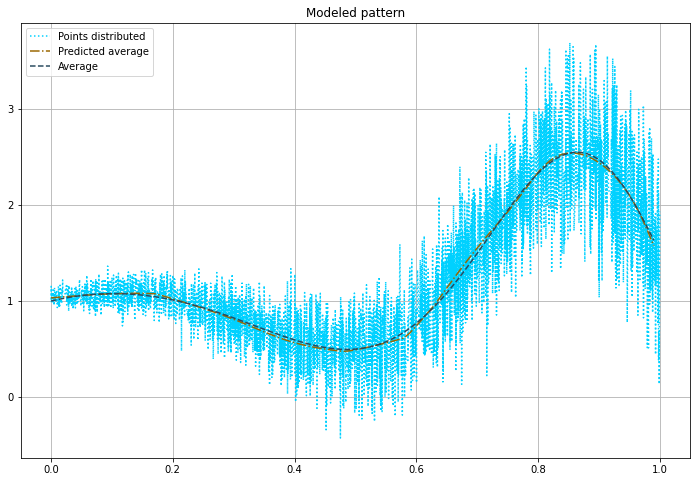

In [9]:
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.plot(xs, ys, color="#00d1ff", linestyle='dotted', label='Points distributed')
plt.plot(xps, [float(z[0]) for z in y_pred], color="#9a6700", linestyle='-.', label='Predicted average')
plt.plot(xps, [y_f(x) for x in xps], color="#294a5f", linestyle='--',  label='Average')


plt.title("Modeled pattern")
plt.legend()
plt.show()

## Модель генерирующая распределения / Model generating distributions

In [10]:
D_in, D_out = 2, 1
H1, H2, H3  = 250, 200, 150

model_dist = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.Tanh(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.ReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Sigmoid(),
).to(device)

print(model_dist)

Sequential(
  (0): Linear(in_features=2, out_features=250, bias=True)
  (1): Tanh()
  (2): Linear(in_features=250, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=150, bias=True)
  (5): ReLU()
  (6): Linear(in_features=150, out_features=1, bias=True)
  (7): Sigmoid()
)


In [11]:
def is_more(a, b, offset = 0.0):
    return 1.0 - offset if a >= b else offset

# Функция генерирующая обучающий набор
def gen_set(xs, ys, N_distr, y_from, y_to, offset = 0.0):
    assert(len(xs) == len(ys))
    
    set_X = []
    set_Y = []
    
    for i in range(len(xs)):
        us = np.random.uniform(y_from, y_to, N_distr)
        for u in us:
            set_X.append( [u, xs[i]] )
            set_Y.append( [is_more(u, ys[i], offset)] )
    
    indexes = list(range(len(set_X)))
    random.shuffle(indexes)
        
    vecx = torch.tensor([set_X[i] for i in indexes], dtype = torch.float32).to(device)
    vecy = torch.tensor([set_Y[i] for i in indexes], dtype = torch.float32).to(device)
    
    return vecx, vecy

ep_step 20
20 	loss_train: 0.09020762890577316 	loss_cv 0.08791007846593857
40 	loss_train: 0.057724129408597946 	loss_cv 0.05518930032849312
60 	loss_train: 0.04248765483498573 	loss_cv 0.040528327226638794
80 	loss_train: 0.03903529420495033 	loss_cv 0.03853646665811539
100 	loss_train: 0.03478532284498215 	loss_cv 0.035057101398706436
120 	loss_train: 0.03453851863741875 	loss_cv 0.03456723317503929
140 	loss_train: 0.034081507474184036 	loss_cv 0.03431364893913269
160 	loss_train: 0.03392418101429939 	loss_cv 0.03411675617098808
180 	loss_train: 0.03527190908789635 	loss_cv 0.0340438112616539
200 	loss_train: 0.03389614075422287 	loss_cv 0.03450287505984306


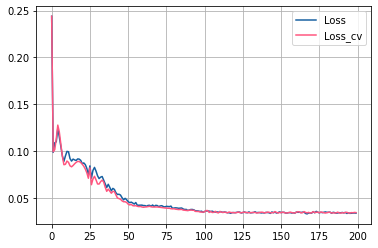

In [12]:
learning_rate  = 0.01
epochs         = 200
ep_step = epochs//10
print("ep_step", ep_step)

optimizer_dist = torch.optim.Adam(model_dist.parameters(), lr = learning_rate)
loss_fn_dist   = torch.nn.MSELoss()

preds = []
y_pred = None

# Размер дискретизации распределения при обучении
N_distr = 20

# Регуляризационный отступ
regul_offset = 0.001

# Диапазон ожидаемых значений Y
y_from = -1
y_to = 4

optimizer_dist.lr = learning_rate

model_dist.train()

indexes = list(range(len(xs)))
random.shuffle(indexes)
cv_size = ceil(0.1*len(xs))
indexes_cv    = indexes[0:cv_size]
indexes_train = indexes[cv_size:]

vecx, vecy = gen_set([xs[i] for i in indexes_train], [ys[i] for i in indexes_train], N_distr, y_from, y_to, offset = regul_offset)
vecx_cv, vecy_cv = gen_set([xs[i] for i in indexes_cv], [ys[i] for i in indexes_cv], N_distr, y_from, y_to, offset = regul_offset)

losses = [];
losses_cv = [];


for epoch in range(epochs):
    vecx, vecy = gen_set(xs, ys, N_distr, y_from, y_to, offset = regul_offset)
    
    y_pred = model_dist(vecx)

    loss_dist = loss_fn_dist(y_pred, vecy)
    
    loss = loss_dist.item()
    losses.append(loss)
    loss_cv = loss_fn_dist(model_dist(vecx_cv), vecy_cv).item()
    losses_cv.append(loss_cv)
    
    if (epoch+1) % ep_step == 0:
        print((epoch+1), "\tloss_train:", loss, "\tloss_cv", loss_cv)

    optimizer_dist.zero_grad()
    
    loss_dist.backward()
    
    optimizer_dist.step()

model_dist.eval()
plt.grid(True)
plt.plot(range(epochs), losses, color="#1660a1", linestyle='solid', label='Loss')
plt.plot(range(epochs), losses_cv, color="#ff557f", linestyle='solid', label='Loss_cv')
plt.legend()
plt.show()

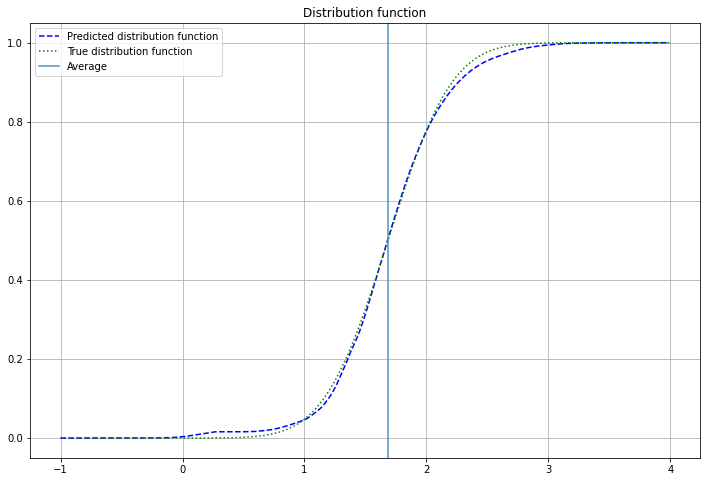

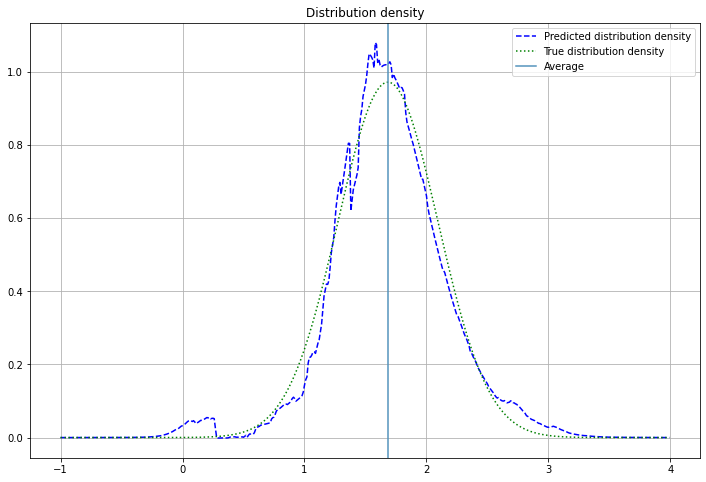

In [17]:
from scipy.stats import norm

x0 = 0.721

step_y = 0.01

pred_distr = lambda y: model_dist( torch.tensor([y, x0], dtype=torch.float32).to(device) )[0].item()

y_range = list(np.arange(y_from, y_to, step_y))

# Distribution function
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.title("Distribution function")
plt.plot(
    y_range,
    [pred_distr(y) for y in y_range],
    color="blue", linestyle='dashed', label='Predicted distribution function')

plt.plot(y_range, norm.cdf(y_range, y_f(x0), sigmf(x0)),
         color="green",
         linestyle='dotted',
         label='True distribution function')

plt.axvline(x=y_f(x0),
    color="#5292bc",
    linestyle='solid',
    label='Average');

plt.legend()
plt.show()

# Distribution density
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.title("Distribution density")
plt.plot(
    y_range,
    [(pred_distr(y+step_y/2.0) - pred_distr(y-step_y/2.0))/step_y for y in y_range],
    color="blue",
    linestyle='dashed',
    label='Predicted distribution density')

plt.plot(y_range, norm.pdf(y_range, y_f(x0), sigmf(x0)),
         color="green",
         linestyle='dotted',
         label='True distribution density')

plt.axvline(x=y_f(x0),
    color="#5292bc",
    linestyle='solid',
    label='Average');

plt.legend()
plt.show()

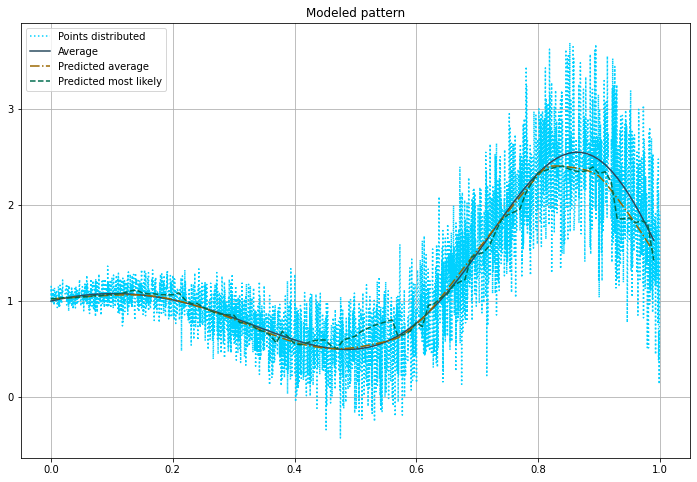

In [16]:
# Построение графиков средних и наиболее вероятных

step_y = 0.01

pred_distr = lambda x, y: model_dist( torch.tensor([y, x], dtype=torch.float32).to(device) )[0].item()

y_range = list(np.arange(y_from, y_to, step_y))

# Предсказываемое среднее по распределениям для каждой точки x
def pred_avg(x):
    result = 0.0;
    y0 = y_range[0];
    F0 =  pred_distr(x, y0);
    for i in range(len(y_range)-1):
        y1 = y_range[i+1];
        F1 =  pred_distr(x, y1);
        result += 0.5 * (y0 + y1) * (F1 - F0);
        y0 = y1;
        F0 = F1;

    return result;

# Предсказываемое наиболее вероятное для каждой точки x
def pred_most_prob(x):
    
    y0 = y_range[0];
    y1 = y_range[1];
    y2 = y_range[2];
    
    F0 =  pred_distr(x, y0);
    F1 =  pred_distr(x, y1);
    F2 =  pred_distr(x, y2);
    
    density_max = 0.0;
    result = y0;
    for i in range(3, len(y_range)):
        y3 = y_range[i];
        F3 =  pred_distr(x, y3);
        density = 0.2 * (2*F3 - F2 + F1 - 2*F0); # Kernel smoothing
        
        if density > density_max:
            density_max = density;
            result = 0.5 * (y1 + y2);
        
        y0 = y1;
        y1 = y2;
        y2 = y3;
        F0 = F1;
        F1 = F2;
        F2 = F3;

    return result;


plt.figure(figsize=(12, 8))
plt.grid(True)
plt.plot(xs, ys, color="#00d1ff", linestyle='dotted', label='Points distributed')
plt.plot(xps, [y_f(x) for x in xps], color="#294a5f", linestyle='solid',  label='Average')
plt.plot(xps, [pred_avg(x) for x in xps], color="#9a6700", linestyle='-.',  label='Predicted average')
plt.plot(xps, [pred_most_prob(x) for x in xps], color="#006c4f", linestyle='--',  label='Predicted most likely')


plt.title("Modeled pattern")
plt.legend()
plt.show()

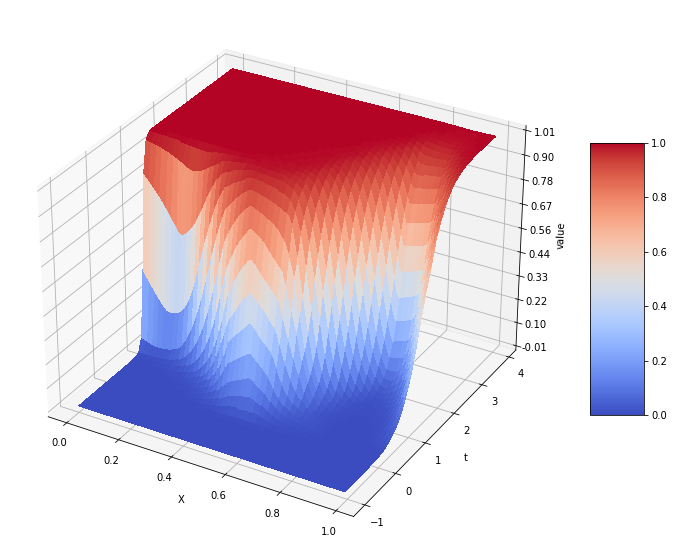

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

x_step = 0.01
y_step = 0.1
xf = 0.0
xt = 1.0

X = []
Y = []
Z = []

x_l = 0
y_l = 0

for x in np.arange(xf, xt, x_step):
    x_l += 1
    y_l = 0
    for y in np.arange(y_from, y_to, y_step):
        y_l += 1
        X.append(x);
        Y.append(y)
        z = model_dist( torch.tensor([y, x], dtype = torch.float32).to(device) )[0].item()
        Z.append( z )

X = np.reshape(X, (x_l, y_l))
Y = np.reshape(Y, (x_l, y_l))
Z = np.reshape(Z, (x_l, y_l))


fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('t')
ax.set_zlabel('value')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)


# Customize the z axis.
ax.set_zlim(-0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()